# Simple Character-level Language Model using LSTM
2017-04-11 jkang  
Python3.5  
TensorFlow1.0.1  
  
- input:  &nbsp;&nbsp;'hello_world_good_morning_see_you_hello_grea'  
- output: 'ello_world_good_morning_see_you_hello_great'  

### Reference:  
- https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py  
- https://github.com/aymericdamien/TensorFlow-Examples
- https://hunkim.github.io/ml/  

### Comment:  
- 단어 단위가 아닌 문자 단위로 훈련함
- 하나의 example만 훈련에 사용함
- Cell의 종류는 BasicLSTMCell을 사용함 (첫번째 Reference 참조)
- dynamic_rnn방식 사용 (기존 tf.nn.rnn보다 더 시간-계산 효율적이라고 함)
- AdamOptimizer를 사용

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Input/Ouput data
char_raw = 'hello_world_good_morning_see_you_hello_great'
char_list = list(set(char_raw))
char_to_idx = {c: i for i, c in enumerate(char_list)}
idx_to_char = {i: c for i, c in enumerate(char_list)}
char_data = [char_to_idx[c] for c in char_raw]
char_data_one_hot = tf.one_hot(char_data, depth=len(
    char_list), on_value=1., off_value=0., axis=1, dtype=tf.float32)
char_input = char_data_one_hot[:-1, :]  # 'hello_world_good_morning_see_you_hello_grea'
char_output = char_data_one_hot[1:, :]  # 'ello_world_good_morning_see_you_hello_great'
with tf.Session() as sess:
    char_input = char_input.eval()
    char_output = char_output.eval()

In [2]:
# Learning parameters
learning_rate = 0.001
max_iter = 200

# Network Parameters
n_input_dim = char_input.shape[1]
n_input_len = char_input.shape[0]
n_output_dim = char_output.shape[1]
n_output_len = char_output.shape[0]
n_hidden = 100

# TensorFlow graph
# (batch_size) x (time_step) x (input_dimension)
x = tf.placeholder(tf.float32, [1, None, n_input_dim])
# (batch_size) x (time_step) x (output_dimension)
y = tf.placeholder(tf.float32, [1, None, n_output_dim])

# Parameters
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output_dim], seed=1))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output_dim], seed=1))
}

# RNN-LSTM cell
def RNN(inputs, weights, biases):
    # Reshape to (time_step) x (batch_size) x (input_dimension)
    inputs = tf.transpose(inputs, [1, 0, 2])
    # Reshape to (time_step)*(batch_size) x (input_dimension)
    inputs = tf.reshape(inputs, [-1, n_input_dim])
    # Split to get a list of time_step tensors of shape (batch_size, input_dimension)
    # final 'inputs' is a list of n_input_len elements
    # (=number of frames)
    inputs = tf.split(value=inputs, num_or_size_splits=n_input_len, axis=0)

    lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = tf.nn.dynamic_rnn(lstm, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

def softmax(x):
    rowmax = np.max(x, axis=1)
    x -= rowmax.reshape((x.shape[0] ,1)) # for numerical stability
    x = np.exp(x)
    sum_x = np.sum(x, axis=1).reshape((x.shape[0],1))
    return x / sum_x

pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [3]:
# Learning
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_x = char_input.reshape((1, char_input.shape[0], n_input_dim))
    train_y = char_output.reshape((1, char_output.shape[0], n_output_dim))
    for i in range(max_iter):
        _, loss, p = sess.run([optimizer, cost, pred],
                              feed_dict={x: train_x, y: train_y})
        if i is max_iter-1:
            pred_act = softmax(p)
        pred_out = np.argmax(p, axis=1)
        print('Epoch: {:>4}'.format(i + 1), '/', str(max_iter),
              'Cost: {:4f}'.format(loss), 'Predict:', ''.join([idx_to_char[i] for i in pred_out]))

Epoch:    1 / 200 Cost: 3.842885 Predict: iiiiiiiiiiiiiiiiiiiiiimiiiiiiiiiiiiiiitiiii
Epoch:    2 / 200 Cost: 3.733372 Predict: iiiiiiiiiiiiiiiiiiiiiimiiiiiiiiittiiiitiiii
Epoch:    3 / 200 Cost: 3.629220 Predict: iiiiitiiititiiiiiiiiimmimiiiiiiittittttitii
Epoch:    4 / 200 Cost: 3.526526 Predict: iiiiittittitiiiiiiiimmmimiiiiiiittittttttti
Epoch:    5 / 200 Cost: 3.422292 Predict: iiiiittittitiiiiimiimgggmmiismittthtttttttt
Epoch:    6 / 200 Cost: 3.314143 Predict: iiiiitttttittttitmitmgggmmggsmtttuhhgtttttt
Epoch:    7 / 200 Cost: 3.200549 Predict: iiiiittttttttttitmmtmgggggggshhuuuuuggttttt
Epoch:    8 / 200 Cost: 3.082167 Predict: iiiiittttttttttitmmt_g_g__gguuguuuuuggtttgg
Epoch:    9 / 200 Cost: 2.965826 Predict: iiiiitttttttttt__m_______________uuug______
Epoch:   10 / 200 Cost: 2.872566 Predict: iiiiittttt__t______________________________
Epoch:   11 / 200 Cost: 2.821098 Predict: iiiiitttto_________________________________
Epoch:   12 / 200 Cost: 2.760385 Predict: iiiiitttoo__

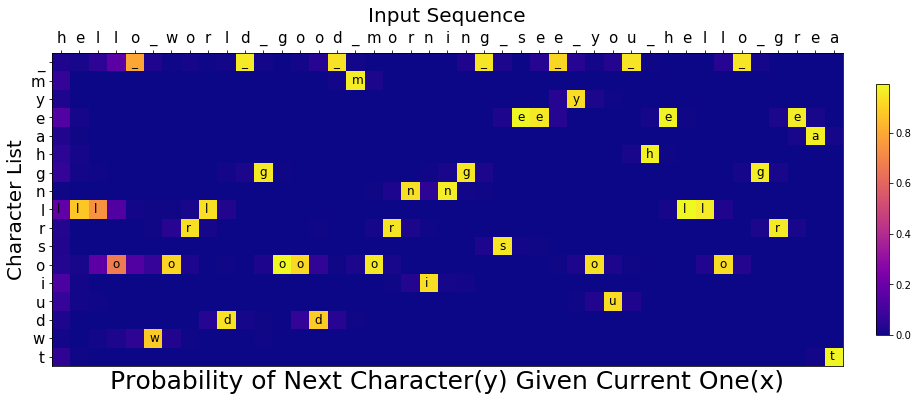

In [9]:
# Probability plot
fig, ax = plt.subplots()
fig.set_size_inches(15,20)
plt.title('Input Sequence', y=1.08, fontsize=20)
plt.xlabel('Probability of Next Character(y) Given Current One(x)', fontsize=25, y=1.5)
plt.ylabel('Character List', fontsize=20)
plot = plt.imshow(pred_act.T, cmap=plt.get_cmap('plasma'))
fig.colorbar(plot, fraction=0.015, pad=0.04)
plt.xticks(np.arange(len(char_data)-1), list(char_raw)[:-1], fontsize=15)
plt.yticks(np.arange(len(char_list)), [idx_to_char[i] for i in range(len(char_list))], fontsize=15)
ax.xaxis.tick_top()

# Annotate
for i, idx in zip(range(len(pred_out)), pred_out):
    annotation = idx_to_char[idx]
    ax.annotate(annotation, xy=(i-0.2, idx+0.2), fontsize=12)
    
plt.show()

### Result:
- 대략 55번째 Epoch에서부터 서서히 예측다운 예측이 보이기 시작함
- 200회 Epoch에 이르기까지도 예측이 제대로 되지 않는 경우 발생 (e.g. 첫번째 문자를 'h'가 아닌 'l'로 예측)